In [1]:
import sys
sys.path.append("../scripts/")
from GridMap import *
from mdp import *
import math
import copy
import random
from matplotlib.animation import PillowWriter    #アニメーション保存用
#%matplotlib notebook

In [2]:
class QLearning():
    def __init__(self, grid_map_world):
        self.world = grid_map_world
        self.grid_map = grid_map_world.grid_map
        self.cost_map = np.full(self.grid_map.shape, 1)    #その地点が持つコスト
        self.q_map = np.full(self.grid_map.shape+tuple([9]), 0.0)
        self.flagTraverse_map = np.full(self.grid_map.shape, 0)
        self.pathFlag = np.full(self.grid_map.shape, False)
        self.gamma = 1.0
        self.alpha = 0.5
        self.epsilon = 0.7
        
    def draw(self, ax, elems):
        robot_state = copy.copy(self.world.start_index)
        self.flagTraverse_map = np.full(self.grid_map.shape, 0)
        for i in range(500):
            robot_state_old = copy.copy(robot_state)
            if(random.random() < self.epsilon):
                a = self.maxQAgent(robot_state)
            else:
                a = self.randomPolicy(robot_state)
                
            if(a == 1 or a == 2 or a == 8):
                robot_state[0] += 1
            elif(a == 4 or a == 5 or a == 6):
                robot_state[0] -= 1
            if(a == 2 or a == 3 or a == 4):
                robot_state[1] += 1
            elif(a == 6 or a == 7 or a == 8):
                robot_state[1] -= 1
            
            self.updateQ(robot_state_old, a, robot_state)
            self.flagTraverse_map[robot_state_old[0]][robot_state_old[1]] += 1

            if(robot_state == self.world.goal_index):
                self.q_map[robot_state_old[0]][robot_state_old[1]][a] = 0.0
                r = patches.Rectangle(
                    xy=(robot_state[0]*self.world.grid_step[0], robot_state[1]*self.world.grid_step[1]),
                    height=self.world.grid_step[0],
                    width=self.world.grid_step[1],
                    color="blue",
                    fill=True,
                    alpha=0.5
                )
                elems.append(ax.add_patch(r))
                break
            
            if(self.isOutOfBounds(robot_state)):
                break
            
            #エピソード内の経路を描画
            r = patches.Rectangle(
                xy=(robot_state[0]*self.world.grid_step[0], robot_state[1]*self.world.grid_step[1]),
                height=self.world.grid_step[0],
                width=self.world.grid_step[1],
                color="red",
                fill=True,
                alpha=0.5
            )
            elems.append(ax.add_patch(r))
            
        #行動価値関数描画
        for x in range(len(self.grid_map)):
            for y in range(len(self.grid_map[0])):
                if(self.grid_map[x][y] == '0'):
                    continue
                if(False):
                    c_num = int(self.maxQAgent([x, y]))
                    if(c_num == 0):
                        c = "black"
                    elif(c_num == 1):
                        c = "saddlebrown"
                    elif(c_num == 2):
                        c = "magenta"
                    elif(c_num == 3):
                        c = "blue"
                    elif(c_num == 4):
                        c = "cyan"
                    elif(c_num == 5):
                        c = "green"
                    elif(c_num == 6):
                        c = "lime"
                    elif(c_num == 7):
                        c = "yellow"
                    elif(c_num == 8):
                        c = "orange"
                    elif(c_num == 9):
                        c = "red"
                    else:
                        c = "white"
                else:
                    #map1 : 20
                    #cost_adj = 7    #map2
                    c_num = -self.maxQ([x, y])
                    c_num = int(c_num * 7) #Black→Blue
                    if(c_num > 0xff): #Blue → Cyan
                        c_num = (c_num-0xff)*16*16 + 0xff
                        if(c_num > 0xffff): #Cyan → Green
                            c_num = 0xffff - int((c_num-0x100ff)*4/256)
                            if(c_num < 0xff00): #Green →Yellow
                                c_num = (0xff00-c_num)*65536+0xff00
                                if(c_num > 0xffff00): #Yellow → Red
                                    c_num = 0xffff00 - int((c_num-0xffff00)*0.5/65536)*256
                    c = '#' + format(int(c_num), 'x').zfill(6)
                r = patches.Rectangle(
                    xy=(x*self.world.grid_step[0], y*self.world.grid_step[1]),
                    height=self.world.grid_step[0],
                    width=self.world.grid_step[1],
                    color=c,
                    fill=True,
                    alpha=0.8
                )
                #elems.append(ax.add_patch(r))
    
    def updateQ(self, s, a, s_):
        if(self.isOutOfBounds(s_)):
            self.q_map[s[0]][s[1]][a] -= 100
        elif(self.isObstacle(s_)):
            self.q_map[s[0]][s[1]][a] -= 100
        else:
            q = self.Q(s, a)
            q_ = self.maxQ(s_)
            self.q_map[s[0]][s[1]][a] = (1- self.alpha) * q + self.alpha * (self.r(s, a, s_) + self.gamma * q_)
    
    def maxQAgent(self, s):
        q_value = self.Q(s, 0)
        pi = 0
        for a in range(9):
            sDash = copy.copy(s)
            if(a == 1 or a == 2 or a == 8):
                sDash[0] += 1
            elif(a == 4 or a == 5 or a == 6):
                sDash[0] -= 1
            if(a == 2 or a == 3 or a == 4):
                sDash[1] += 1
            elif(a == 6 or a == 7 or a == 8):
                sDash[1] -= 1
            if(self.isOutOfBounds(sDash)):
                self.q_map[s[0]][s[1]][a] = -100
                continue
            elif(self.isObstacle(sDash)):
                self.q_map[s[0]][s[1]][a] = -100
                continue
            else:
                if(q_value < self.Q(s, a)):
                    q_value = self.Q(s, a)
                    pi = a
        return pi
    
    def maxQ(self, sDash):
        return np.max(self.q_map[sDash[0]][sDash[1]])
    
    def Q(self, s, a):
        return self.q_map[s[0]][s[1]][a]
    
    def p(self, s, a, s_):
        if(s_[0]<0 or s_[0]>self.grid_map.shape[0]-1): #地図の範囲外か（x軸方向）
            return 0.0
        elif(s_[1]<0 or s_[1]>self.grid_map.shape[1]-1):
            return 0.0
        else:
            if(a == 0):
                if(s_[0]-s[0] == 0 and s_[1]-s[1] == 0):
                    return 1.0
                else:
                    return 0.0                
            elif(a == 1):
                if(s_[0]-s[0] == 1 and s_[1]-s[1] == 0):
                    return 1.0
                else:
                    return 0.0
            elif(a == 2):
                if(s_[0]-s[0] == 1 and s_[1]-s[1] == 1):
                    return 1.0
                else:
                    return 0.0
            elif(a == 3):
                if(sDash[0]-s[0] == 0 and sDash[1]-s[1] == 1):
                    return 1.0
                else:
                    return 0.0
            elif(a == 4):
                if(s_[0]-s[0] == -1 and s_[1]-s[1] == 1):
                    return 1.0
                else:
                    return 0.0
            elif(a == 5):
                if(s_[0]-s[0] == -1 and s_[1]-s[1] == 0):
                    return 1.0
                else:
                    return 0.0
            elif(a == 6):
                if(s_[0]-s[0] == -1 and s_[1]-s[1] == -1):
                    return 1.0
                else:
                    return 0.0
            elif(a == 7):
                if(s_[0]-s[0] == 0 and s_[1]-s[1] == -1):
                    return 1.0
                else:
                    return 0.0
            elif(a == 8):
                if(s_[0]-s[0] == 1 and s_[1]-s[1] == -1):
                    return 1.0
                else:
                    return 0.0
                                                    
    def r(self, s, a, s_):
        if(s == self.world.goal_index):
            return 0.0
        if(a == 0):
            return -30.0
        return self.moveCost(s, s_) - self.flagTraverse_map[s_[0]][s_[1]] * 2
    
    def moveCost(self, s, s_):
        return -math.sqrt((s[0]-s_[0])**2+(s[1]-s_[1])**2)

    def randomPolicy(self, s):
        while(1):
            s_ = copy.copy(s)
            a = int(random.random() * 8) + 1
            if(a == 1 or a == 2 or a == 8):
                s_[0] += 1
            elif(a == 4 or a == 5 or a == 6):
                s_[0] -= 1
            if(a == 2 or a == 3 or a == 4):
                s_[1] += 1
            elif(a == 6 or a == 7 or a == 8):
                s_[1] -= 1
            
            if(self.isOutOfBounds(s_)):
                continue
            elif(self.isObstacle(s_)):
                continue
            else:
                return a

    def drawPath(self, ax, elems):
        self.pathFlag = np.full(self.grid_map.shape, False)
        index = copy.copy(self.world.start_index)
        while(1):
            a = self.PI(index)
            if(a == 0):
                break
            if(a == 1 or a == 2 or a == 8):
                index[0] += 1
            elif(a == 4 or a == 5 or a == 6):
                index[0] -= 1
            if(a == 2 or a == 3 or a == 4):
                index[1] += 1
            elif(a == 6 or a == 7 or a == 8):
                index[1] -= 1
            
            if(index[0]<0 or index[0]>self.cost_map.shape[0]-1): #地図の範囲外か（x軸方向）
                break
            if(index[1]<0 or index[1]>self.cost_map.shape[1]-1): #地図の範囲外か（y軸方向）
                break
            if(self.isObstacle(index)):
                break
            if(self.pathFlag[index[0]][index[1]]):
                break
            if(index == self.world.goal_index):
                break
            
            self.pathFlag[index[0]][index[1]] = True
            r = patches.Rectangle(
                xy=(index[0]*self.world.grid_step[0], index[1]*self.world.grid_step[1]),
                height=self.world.grid_step[0],
                width=self.world.grid_step[1],
                color="red",
                fill=True,
                alpha=0.5
            )
            elems.append(ax.add_patch(r))
            
    def isObstacle(self, s):
        if(self.grid_map[s[0]][s[1]] == '0'):
            return True
        else:
            return False
    
    def isOutOfBounds(self, s):
        if(s[0]<0 or s[0]>self.cost_map.shape[0]-1):
            return True
        elif(s[1]<0 or s[1]>self.cost_map.shape[1]-1):
            return True
        return False
    
    def listNeigbor(self, index):
        neigbor_index = []
        for i in range(-1, 2):
            if(index[0]+i<0 or index[0]+i>self.cost_map.shape[0]-1): #地図の範囲外か（x軸方向）
                continue;
            for j in range(-1, 2):
                if(index[1]+j<0 or index[1]+j>self.cost_map.shape[1]-1): #地図の範囲外か（y軸方向）
                    continue
                elif(self.grid_map[index[0]+i][index[1]+j] == '0'): #障害物か
                    continue
                else:
                    neigbor_index.append([index[0]+i, index[1]+j])
        return neigbor_index

<IPython.core.display.Javascript object>


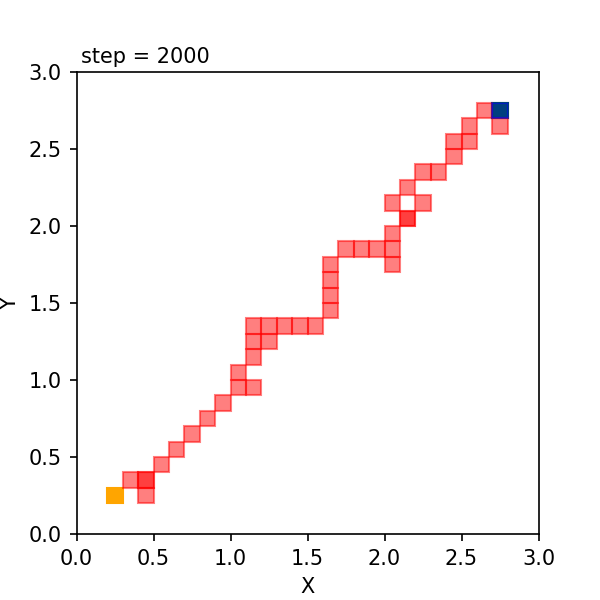

In [3]:
if __name__ == "__main__":
    time_span = 200
    time_interval = 0.1
    
    grid_step = np.array([0.1, 0.1])
    grid_num = np.array([30, 30])
    
    map_data = "../csvmap/map1.csv"
    
    world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, debug=False)
    world.append(QLearning(world))
    
    world.draw()
    #world.ani.save('greedy_map2.gif', writer='pillow', fps=60)    #アニメーション保存